# Generating CMIP forcing for Wflow.jl

With eWaterCycle we can also generate forcing data from CMIP climate models.

Please do note that the following issue in Wflow.jl has to be resolved first:
https://github.com/Deltares/Wflow.jl/issues/308

In [1]:
from pathlib import Path

import ewatercycle.forcing
import ewatercycle.models
import numpy as np


/home/bart/miniconda3/envs/lock2/lib/python3.12/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


## CMIP forcing

The CMIP dataset and ensemble can be selected below. The shape file and Wflow DEM of the catchment are required.

The CMIP data will be downloaded, and the forcing will be generated.

In [2]:
cmip_dataset = {
    "dataset": "GFDL-ESM2G",
    "project": "CMIP5",
    "grid": "gr",
    "exp": "historical",
    "ensemble": "r1i1p1",
}

wflow_forcing = ewatercycle.forcing.sources["WflowJlForcing"].generate(
    dataset=cmip_dataset,
    start_time="1990-01-01T00:00:00Z",
    end_time="1992-12-31T00:00:00Z",
    shape=Path("data/wflow/sbm_moselle/moselle.shp"),  # Doesn't need to exist if you specify extract_region.
    dem_file="/data/wflow/sbm_moselle/staticmaps-moselle.nc",
    extract_region={
        "start_longitude": 3,
        "end_longitude": 11, 
        "start_latitude": 47, 
        "end_latitude": 51,
    }
)

# wflow_forcing = ewatercycle.forcing.sources["WflowJlForcing"].load(
#     "/home/bart/esmvaltool_output/ewcrepvdu1tkfu_20241128_101417/work/diagnostic/script"
# )

## Parameter set

Wflow.jl requires parameter data to be able to run. Some example datasets are available on the Wflow.jl documentation.

Here we use the example dataset for the Moselle catchment.

In [3]:
from ewatercycle.base.parameter_set import ParameterSet

parameters_moselle = ParameterSet(
    name="moselle",
    directory=Path("/data/wflow/sbm_moselle"),
    target_model="WflowJl",
    config="sbm_config.toml"   
)

Now we can setup the model:

In [4]:
model = ewatercycle.models.sources["WflowJl"](
    parameter_set=parameters_moselle,
    forcing=wflow_forcing
)

cfg_file,_ = model.setup()

In [5]:
cfg_file

'/home/bart/ewatercycle/output/wflowjl_20241128_103401/wflow_ewatercycle.toml'

The model will be initialized using the generated configuration file:

In [6]:
model.initialize(cfg_file)

To make the model advance a time step, use `.update()`:

In [7]:
model.update()

We can extract timeseries for subcatchments using the Basic Model Interface:

In [8]:
#      Location A, Location B.
lats = [50.00,     49.5]
lons = [ 7.12,      6.37]

ntimesteps = int(model.end_time / model.time_step) - 1
q_locs = np.zeros((ntimesteps, 2,))
dtimes = []
for tstep in range(ntimesteps):
    model.update()
    q_locs[tstep] = model.get_value_at_coords("lateral.river.q_av", lats, lons)
    dtimes.append(model.time_as_datetime)

After extracting the discharge data, we can plot it:

Text(0, 0.5, 'discharge [m3/s]')

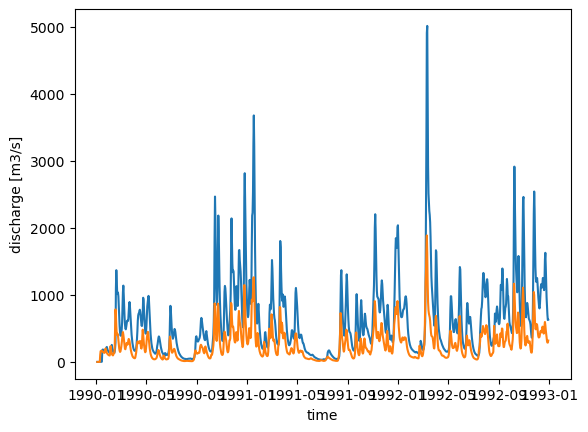

In [9]:
import matplotlib.pyplot as plt
plt.plot(dtimes, q_locs[:, 0])
plt.plot(dtimes, q_locs[:, 1])
plt.xlabel("time")
plt.ylabel("discharge [m3/s]")